## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import optilibrary as libopt

In [4]:
from scipy.linalg import norm
# Python class for regression problems
def F(A, x, y, lbda):
    n, d = A.shape
    return norm(A.dot(x) - y)**2/ (2.*n) + lbda*norm(x,2)**2/2.
def f_i(i, A, x, y, lbda):
    return norm(A[i].dot(x) - y[i])**2 /(2.) + lbda*norm(x)**2/2.

def gradF(A, x, y, lbda):
    n, d = A.shape
    return A.T.dot(A.dot(x) - y) / n + lbda * x

def grad_fi(i, A, x, y, lbda):
    a_i = A[i]
    return (a_i.dot(x) - y[i]) * a_i + lbda*x

def lipconst(A, lbda):
    n, d = A.shape
    L = norm(A, ord=2) ** 2 / n + lbda
    return L



class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad
        
    # Partial gradient knowing the model (useful for certain gradient techniques)
    def grad_ai(self,i,aix,x=None):
        a_i = self.A[i]
        if self.loss=='l2':
            grad = (aix - self.y[i]) * a_i 
            if (self.lbda>0):
                grad += self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* aix))
            if (self.lbda>0):
                grad += self.lbda * x
        return grad        

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda



In [5]:
X_train, y_train, X_test, y_test = libopt.importData(p=0.2)
n, d = X_train.shape
print(X_train.shape)
lbda = 1. / n ** (0.5)

(16512, 9)


In [6]:
#Create models using data
pblinreg = RegPb(X_train, y_train, lbda, loss='l2')

In [7]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

0.20441741636810176
3.642471005074279e-09


## Question 1: 
- Implement stochastic gradient and 

In [27]:
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0,with_replace=False,verbose=False): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            average: Indicates whether the method computes the average of the iterates 
                0: No averaging (default)
                1: With averaging
            scaling: Use a diagonal scaling
                0: No scaling (default)
                1: Average of magnitudes (RMSProp)
                2: Normalization with magnitudes (Adagrad)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            x_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)
    
    # Average (if needed)
    if average:
            xavg=np.zeros(len(x))
    
    #Scaling values
    if scaling>0:
        mu=1/(2 *(n ** (0.5)))
        v = np.zeros(d)
        beta = 0.8
    
    obj = problem.fun(x) 
    objvals.append(obj);
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    # if verbose:
    #     # Plot initial quantities of interest
    #     print("Stochastic Gradient, batch size=",nb,"/",n)
    #     print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
    #     print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    k=0
    e=1
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
        
        if scaling>0:
            if scaling==1:
                # RMSProp update
                v = beta*v + (1-beta)*sg*sg
            elif scaling==2:
                # Adagrad update
                v = v + sg*sg 
            sg = sg/(np.sqrt(v+mu))

        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice==1:
            sk = float(step0/(np.sqrt(k+1)))
            x[:] = x - sk * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Measure divergence 
        
        if average:
            xavg = k/(k+1) *xavg + x/(k+1) 
            nmin = norm(xavg-xtarget)
            obj = problem.fun(xavg)
        else:
            obj = problem.fun(x)
            nmin = norm(x-xtarget)
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        # if (k*nb) % n == 0:
        if k*nb - e*n >= 0: 
            print("Epoch", e, end='\r')
            e+=1
            objvals.append(obj)
            normits.append(nmin)
    
    # Plot quantities of interest for the last iterate (if needed)
    # if (k*nb) % n > 0:
    objvals.append(obj)
    normits.append(nmin)
    print('')
    
    # Outputs
    if average:
        x_output = xavg.copy()
    else:
        x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)

- compare its performance with that of your gradient descent implementation from Part 1 on the same problem and dataset. 
- What happens when both methods are run using the same stepsize? 
- Do your observations confirm what has been discussed during the lecture?

We consider the same dataset as in Part 1 and compare the performance of the stochastic descent and gradient descent technques. To ensure comparability, the following parameters are fixed:
- Number of epochs (eg. number of accesses to the gradient) is set to 30
- $x_0$ the initial estimate is set to **0**$\in\mathbb{R}^d$.

As the SG method is not always guaranteed to converge, we opt to compare the methods by making use of a decreasing step size.
- The step parameter is fixed to $\frac{1}{\sqrt{k+1}}$ at iteration $k$.

In [ ]:
nb_epochs = 30
x0 = np.zeros(d)

import time
elapsed = []

x = []; obj=[]; its=[]
batches = [1, int(n/500), int(n/100), int(n/10), int(n/2), n]
btitle = ['1', 'n/500', 'n/100', 'n/10', 'n/2', 'n']

for i in range(len(batches)):
    nbset = batches[i]
    print(f'niter={int((nb_epochs*n)/nbset)}, nb={nbset}')
    st = time.time()
    x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int((nb_epochs*n)/nbset),nb=nbset)
    et = time.time()
    elapsed.append(et-st)
    x.append(x_a)
    obj.append(obj_a)
    its.append(nits_a)
    
#To even out
obj = np.array([np.array(o[-nb_epochs-1:-1]) for o in obj])
obj.shape

Plot

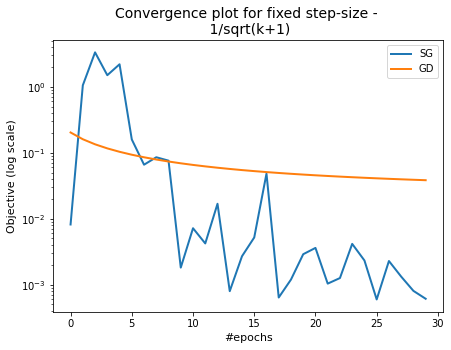

In [108]:
plt.figure(figsize=(7, 5))
plt.semilogy(obj[0]-f_min_lin, lw=2)
plt.semilogy(obj[-1]-f_min_lin, lw=2)
plt.title("Convergence plot for fixed step-size - \n 1/sqrt(k+1)", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11)
plt.legend(('SG', 'GD'));

This run beautifully illustrates typical characteristics of the 2 algorithms when compared one to the other:

As discussed in class, the stochastic gradient algorithm is not a descent method; behaviour which is clearly observed here in that the objective value is sometimes increasing over successive epochs. The oscillatory phase following a phase of quick descent corresponds to class discussion in that we observe the method stalling when the steps get too small to make a big improvment.

Conversely, gradient descent is guaranteed to descend over every successive iteration and we observe this behaviour clearly below.

For this method, and for a fixed number of epochs, it seems that SG performs better than the method from which it was derived.



## Question 2: 
Find a value for the batch size that realizes a good compromise between gradient descent and stochastic gradient.

We consider several different batch sizes, each for a fixed number of epochs and compare this to the gradient descent method (where the batch size is merely $n$, the number of entries).

$$\text{\#batch} = \left\{1, \frac{n}{100}, \frac{n}{10}, \frac{n}{5}, n \right\}$$

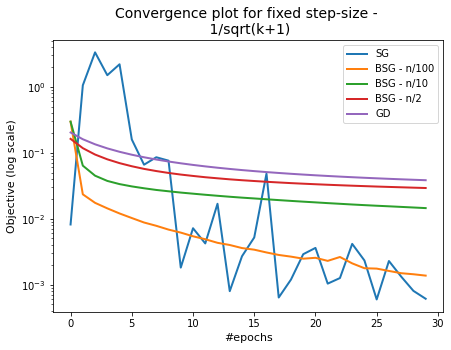

In [109]:
# Plot the comparison of variants of batch SGD with the same stepsize rule
plt.figure(figsize=(7, 5))
for i in range(len(batches)):
    plt.semilogy(obj[i]-f_min_lin, lw=2)
plt.title("Convergence plot for fixed step-size - \n 1/sqrt(k+1)", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11)

plt.legend(['SG', 'BSG - n/100', 'BSG - n/10', 'BSG - n/2', 'GD']);


[0.20502658 0.20578442 0.2188588  0.23354339 0.24266657]


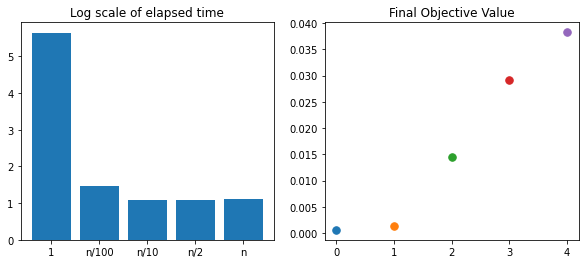

In [110]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.bar(btitle, np.log(elapsed))
plt.title('Log scale of elapsed time')

plt.subplot(1,2,2)
for i in range(len(obj)):
    plt.plot(i, obj[i][-1]-f_min_lin, '.-', markersize=15)

plt.title('Final Objective Value');
print(obj[:,-1])

BSG with n/100 seems to perform almost exactly as well as vanilla SG, but with a runtime comparable to smaller batch size. We conclude that batch stochastic gradient with a batch size of n/100 would be satisfactory. 

## *Question 3:* 

Compare your stochastic gradient method with one of the advanced variants seen in class on your selected problem. Discuss your results, and what interpretation you can draw from them.

We consider SG and compare it with averaging.
(Only 2 reps because big dataset)

In [171]:
# Comparison of stochastic gradient with and without averaging
nb_epochs = 50
x0 = np.zeros(d)

nruns = 5

obj_a = []
obj_b = []
obj_c = []

nbset = int(n/1000)
niter=int(nb_epochs*n/nbset)

for i in range(nruns):
    # Run standard stochastic gradient without averaging
    _, oa, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter, nb=nbset)
    obj_a.append(oa)
    # Run stochastic gradient with averaging
    _, ob, _= stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter, nb=nbset,average=1)
    obj_b.append(ob)
    # # Stochastic gradient (batch size 1) with RMSProp diagonal scaling
    # _, oc,_ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter,nb=nbset,average=0,scaling=1)
    # obj_c.append(oc)


Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50


In [172]:
obj_a = np.array(obj_a)
obj_b = np.array(obj_b)
obj_c = np.array(obj_c)

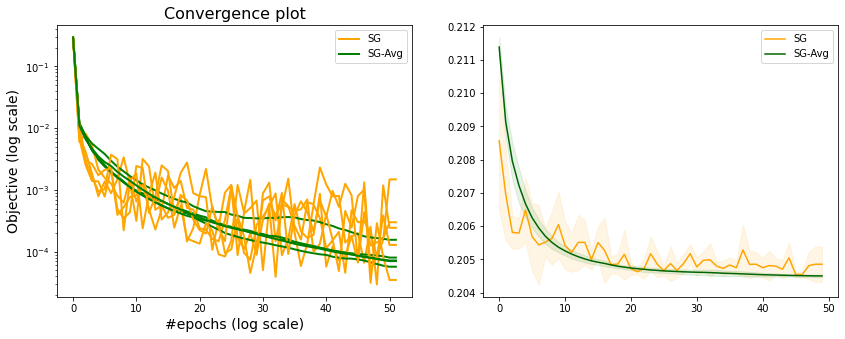

In [173]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
for i in range(nruns):
    plt.semilogy(obj_a[i]-f_min_lin,color='orange',lw=2)
    plt.semilogy(obj_b[i]-f_min_lin,color='g', lw=2)
    # plt.semilogy(obj_c[i]-f_min_lin,color='indianred', lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(('SG', 'SG-Avg'))

plt.subplot(1,2,2)
t = np.arange(nb_epochs)
ma = np.mean(obj_a[:,2:], axis=0)
sda = np.std(obj_a[:,2:], axis=0)
plt.plot(t, ma, 'orange')
plt.fill_between(t, ma - sda, ma + sda, color='orange', alpha=0.1)

mb = np.mean(obj_b[:,2:], axis=0)
sdb = np.std(obj_b[:,2:], axis=0)
plt.plot(t, mb, 'darkgreen')
plt.fill_between(t, mb - sdb, mb + sdb, color='g', alpha=0.1)

plt.legend(('SG', 'SG-Avg'));

As mentioned above, SG is not a descent method and so not guaranteed to descend at each iteration. It will, however, descend on average. By averaging over iterates, one is essentially enforcing the 'descent' behaviour of SGD. Moreover, averaging will also decrease variance in the method. 

Diagonal Scaling

In [ ]:
# Comparison of stochastic gradient with and without diagonal scaling

nb_epochs = 60
n = pblinreg.n
x0 = np.zeros(d)

nbset = int(n/500)
n_iter = int(nb_epochs*n/nbset)

# Stochastic gradient (batch size 1) without diagonal scaling
x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=n_iter,nb=nbset)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling
x_b, obj_b, nits_b = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=n_iter,nb=nbset,average=0,scaling=1)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Constant step size
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0,step0=0.2, n_iter=n_iter,nb=nbset,average=0,scaling=2)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Decreasing step size
x_d, obj_d, nits_d = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=n_iter,nb=nbset,average=0,scaling=2)

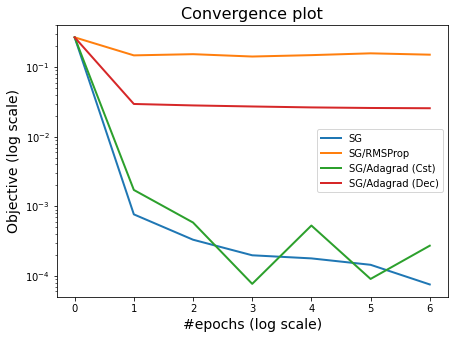

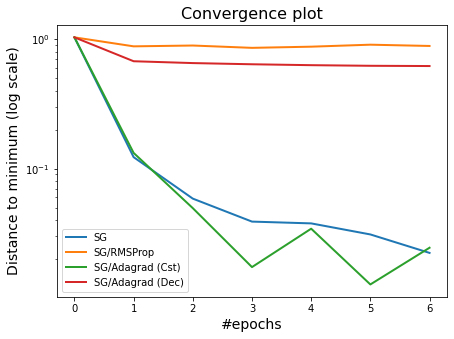

In [16]:
# Plot the results - Comparison of stochastic gradient with and without diagonal scaling
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SG/RMSProp", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(obj_d-f_min_lin, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# # In terms of distance to the minimum (logarithmic scale)
# plt.figure(figsize=(7, 5))
# plt.semilogy(nits_a, label="SG", lw=2)
# plt.semilogy(nits_b, label="SG/RMSProp", lw=2)
# plt.semilogy(nits_c, label="SG/Adagrad (Cst)", lw=2)
# plt.semilogy(nits_d, label="SG/Adagrad (Dec)", lw=2)
# plt.title("Convergence plot", fontsize=16)
# plt.xlabel("#epochs", fontsize=14)
# plt.ylabel("Distance to minimum (log scale)", fontsize=14)
# plt.legend()